`firefly/ntbks/reader_tutorial.ipynb`

In [1]:
%load_ext autoreload
%autoreload 2
from IPython.display import YouTubeVideo

A recording of this jupyter notebook in action is available at:

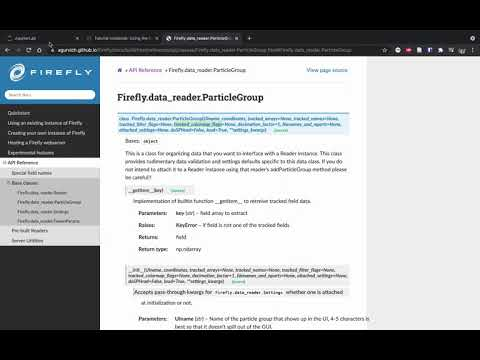

In [2]:
YouTubeVideo("lYPGa6DibOk")

In [3]:
import sys
import os
import numpy as np
sys.path.insert(0,"/Users/agurvich/research/repos/firefly/src/")
from firefly.data_reader import Reader,ArrayReader,ParticleGroup

# Tutorial notebook: Using the `Reader` class
One of the main purposes of Firefly is to enable users to interactively explore their *own* data (or else interactively explore someone else's respective own data). While it is possible to format one's data manually using a text editor we have provided a python API for producing the `.json` files that are necessary to run an iteration of firefly.

The central piece of that API is the `firefly.data_reader.Reader` class, which acts to collect the different parts of the API together to produce consistently formatted and linked `.json` files that the Firefly webapp can interpret. The `Reader` class is <a href="https://ageller.github.io/Firefly/docs/build/html/data_reader/reader.html">documented here</a> but here we only provide a brief example of how to use the API. 

## Creating a Reader instance
To begin, we'll start by initializing a `Reader` object. Users are encouraged to familiarize themselves with the different keyword arguments through the documentation linked above. 

Perhaps the most important keyword argument is the `JSONdir`, which tells your `Reader` object where it should collect the different `.json` files it will produce. The `.json` files have to be readable from the `firefly/static/data` directory of the iteration of Firefly that's trying to open the data. The `Reader` class will automatically create a shortcut to the directory if you don't choose a path that lives in `firefly/static/data`. If you enter a relative path it will assume you mean relative to your `${HOME}` directory. If no `JSONdir` is provided then it will default to `${HOME}/<JSONprefix>` (which itself defaults to `Data` if nothing is passed). 

In [4]:
## initialize a Reader object, cwd will be firefly/ntbks
JSONdir = os.path.abspath(os.path.join(os.getcwd(),'..','static','data','tutorial'))
my_reader = Reader(JSONdir=JSONdir)

In [5]:
## let's create some sample data, a grid of points in a 3d cube
my_coords = np.linspace(-10,10,20)
xs,ys,zs = np.meshgrid(my_coords,my_coords,my_coords)
xs,ys,zs = xs.flatten(),ys.flatten(),zs.flatten()
coords = np.array([xs,ys,zs]).T

## we'll pick some random field values to demonstrate filtering/colormapping
fields = np.random.random(size=xs.size)

## Store the coordinates in a ParticleGroup
Particle data is validated and organized in `firefly.data_reader.ParticleGroup` objects. In general users should not sub-class the `ParticleGroup` class but if you're an enterprising user with a specific use case I'm a tutorial not a cop! For details about how the `ParticleGroup` class works, check the <a href="https://ageller.github.io/Firefly/docs/build/html/data_reader/particle_group.html">particle group documentation</a>.

For our purposes, we'll take advantage of the fact that any keyword arguments passed here go directly to the `particleGroup.settings_default` dictionary which controls which elements appear in the particle panes in the UI, see the <a href="https://ageller.github.io/Firefly/docs/build/html/data_reader/settings.html">settings documentation</a> or see `settings_tutorial.ipynb` for an example.

**Note:**
Sometimes data is too large to load directly into Firefly, we encourage users who are trying a new dataset for the first time to use the `decimation_factor` keyword argument to reduce the dataset size by the factor specified (the implementation is just a `shuffle(coords)[::decimation_factor]`). 

In [6]:
## create a particle group that contains our test coordinates
my_particleGroup = ParticleGroup(
    'partname',
    coords,
    sizeMult=5, ## increase the size of the particles to make the particles a bit easier to see since there's so few of them
    color = [0,0,1,1], ## make them blue, colors should be RGBA list,
    tracked_arrays=[fields], ## track the dummy field to demonstrate how to pass field data
    tracked_names=['testfield']) ## name the dummy field

## sometimes data is too large to load directly into Firefly
my_decimated_particleGroup = ParticleGroup(
    'decimated',
    coords,
    sizeMult=5, ## increase the size of the particles to make the particles a bit easier to see since there's so few of them
    color = [0,0,1,1], ## make them blue, colors should be RGBA list,
    tracked_arrays=[fields], ## track the dummy field to demonstrate how to pass field data
    tracked_names=['testfield'], ## name the dummy field
    decimation_factor=10)

Make sure each tracked_array (1) has a tracked_filter_flag (0), assuming True.
Make sure each tracked_array (1) has a tracked_colormap_flag (0), assuming True.
Make sure each tracked_array (1) has a tracked_filter_flag (0), assuming True.
Make sure each tracked_array (1) has a tracked_colormap_flag (0), assuming True.


All that's left is to connect the `ParticleGroup` object to the `Reader` object using the `.addParticleGroup` method. 

In [7]:
## instructs my_reader to keep track of my_particleGroup
my_reader.addParticleGroup(my_particleGroup)
my_reader.addParticleGroup(my_decimated_particleGroup)
print(my_reader)
print(my_reader.particleGroups)

Reader with 2 particle groups
[partname - 8000/8000 particles - 1 tracked fields
 decimated - 800/8000 particles - 1 tracked fields]


Notice that the decimation factor is represented by the fraction 800/8000 in the second particle group "decimated". 

## Outputting to JSON
At this point we're ready to output our data to `.json` format in order to load in with firefly. The `Reader` object will automatically dump all of the necessary files associated with each of the `ParticleGroup` objects and `Settings` objects we've attached to it as described in the <a href="https://ageller.github.io/Firefly/docs/build/html/data_reader/reader.html">reader documentation</a>.

In [8]:
## have the reader dump all its data to the different JSON files
my_reader.dumpToJSON(loud=True)

Outputting: partname - 8000/8000 particles - 1 tracked fields
Outputting: decimated - 800/8000 particles - 1 tracked fields


''

Notice that `.dumpToJSON` returned an empty string, this is because the `.json` files were written to disk. Another option is instead to produce a single `.json` formatted string with all the data that would've been written to disk. This is useful for transmitting data through Flask, which is the subject of another tutorial.

In [9]:
## have the reader dump all its data to a single big string
big_JSON = my_reader.dumpToJSON(loud=True,write_jsons_to_disk=False)

print("big_JSON has %d characters"%len(big_JSON))

Outputting: partname - 8000/8000 particles - 1 tracked fields
Outputting: decimated - 800/8000 particles - 1 tracked fields
big_JSON has 468730 characters


## Using an `ArrayReader` sub-class

The procedure outlined above is a common use case, and so we've provided a sub-class to `firefly.data_reader.Reader`, `firefly.data_reader.ArrayReader` which wraps the `ParticleGroup` and `.addParticleGroup` so the user can get a `Reader` containing their data with a single initialization. It will automatically name particle groups and fields unless they are specified directly (see <a href="https://ageller.github.io/Firefly/docs/build/html/data_reader/reader.html">reader documentation</a>).

In [10]:
my_arrayReader = ArrayReader(
    coords,
    fields=fields,
    JSONdir=JSONdir,
    write_jsons_to_disk=True)

Make sure each tracked_array (1) has a tracked_filter_flag (0), assuming True.
Make sure each tracked_array (1) has a tracked_colormap_flag (0), assuming True.
Outputting: PGroup_0 - 8000/8000 particles - 1 tracked fields
